In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import math
import glob
import shutil

# Extracting Area of Intestest from the Xray Image

In [2]:

import matplotlib.pyplot as plt
import os
import cv2

source_images_folder = os.path.join('.','Dataset',"Train") # the folder containing all the images for ROI selection
image_names = os.listdir(source_images_folder)
labels = os.listdir(os.path.join('.','Dataset',"Train"))
destination_folder = os.path.join('.','Dataset', "cropped_images") # the folder to which the cropped images are stored
#images_dir = []
total = 0
for label in labels:
    temp_dir = os.path.join(source_images_folder,label)
    temp_img = glob.glob(temp_dir + '/*.png')
    label_total = len(temp_img)
    print("About to cropping {} {} images".format(label_total,label))
    for image_dir in temp_img:
        image_name = image_dir.split('\\')[-1]
        final_dest = os.path.join(destination_folder,label)
        if not os.path.exists(final_dest):
            os.mkdir(final_dest)
        image_final_dir = os.path.join(final_dest,image_name)
        reader = Image.open(image_dir).resize([640,640])
        reader = reader.crop((190, 120, 510, 280))
        reader.save(image_final_dir)
    print("{} images has been cropped".format(label))
    total += label_total

print("Completed all images: {}".format(total))

 


    

    #images_dir =  images_dir  + temp_img
    



# reader = Image.open(images_dir[0]).resize([640,640])
# reader = reader.crop((190, 120, 510, 280))

# reader.save()
#alx = plt.imshow(reader, cmap="gray")

# alx = plt.imshow(reader, cmap="gray")


# for image in images_dir:
#     img = cv2.imread(image)
#     plt.figure(figsize=(5,5))
#     fig = plt.gcf()
#     plt.imshow(img[240:600,280:820])  # The ROI, please keep static
#     plt.draw()
#     if not os.path.exists(os.path.join(destination_folder)):
#       os.mkdir(os.path.join(destination_folder))
    
#     plt.savefig(os.path.join(destination_folder,'holla.png'))
#     print('saved ', image)
#     break

# Rebuilding the Classification model using the Area of interest images

In [3]:
# Define the training and validation data directory
train_dir = os.path.join(destination_folder, 'train')
val_dir = os.path.join(destination_folder, 'val')

In [20]:
# Split training data to training and validation set

for label in labels:
  img_path = os.path.join(destination_folder, label)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(label, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(train_dir, label)):
      os.makedirs(os.path.join(train_dir, label))
    shutil.move(t, os.path.join(train_dir, label))

  for v in val:
    if not os.path.exists(os.path.join(val_dir, label)):
      os.makedirs(os.path.join(val_dir, label))
    shutil.move(v, os.path.join(val_dir, label))

Kidney_stone: 625 Images
Normal: 828 Images


In [4]:
batch_size = 128
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(160,320),
                                               class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(160,320), #(64,64)
                                                              class_mode='binary')

Found 1162 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


### Visualise a training Image

In [5]:
sample_training_images, _ = next(train_data_gen) 

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

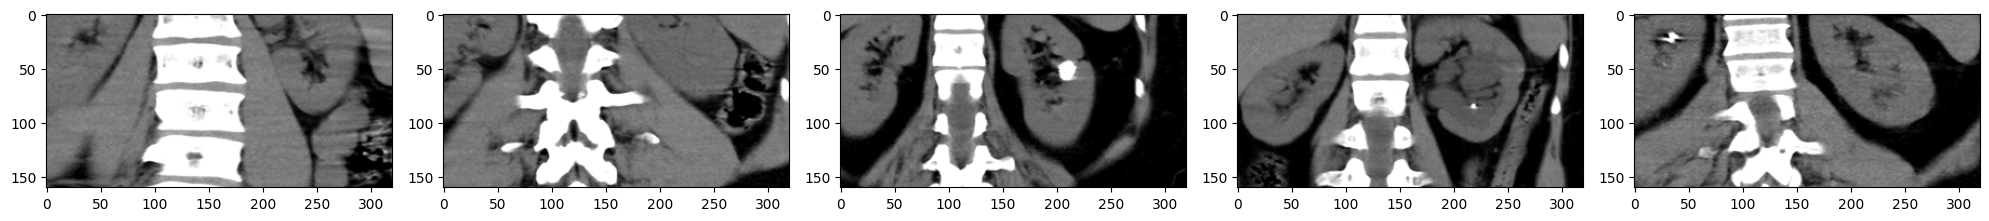

In [7]:
plotImages(sample_training_images[:5])  # Plot images 0-4

Define the Model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(160, 320, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 318, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 159, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 157, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 76, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 38, 128)      0

In [11]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(1162 / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(291  / float(batch_size)))
)

Epoch 1/100
10/10 [==============================] - 53s 5s/step - loss: 0.9479 - accuracy: 0.5138 - val_loss: 0.6685 - val_accuracy: 0.5704
Epoch 2/100
10/10 [==============================] - 50s 5s/step - loss: 0.6805 - accuracy: 0.5843 - val_loss: 0.6707 - val_accuracy: 0.7079
Epoch 3/100
10/10 [==============================] - 48s 5s/step - loss: 0.6576 - accuracy: 0.6317 - val_loss: 0.6392 - val_accuracy: 0.6495
Epoch 4/100
10/10 [==============================] - 47s 5s/step - loss: 0.6009 - accuracy: 0.6747 - val_loss: 0.5703 - val_accuracy: 0.7354
Epoch 5/100
10/10 [==============================] - 47s 5s/step - loss: 0.7210 - accuracy: 0.6239 - val_loss: 0.6493 - val_accuracy: 0.7285
Epoch 6/100
10/10 [==============================] - 47s 5s/step - loss: 0.6051 - accuracy: 0.7358 - val_loss: 0.5538 - val_accuracy: 0.7491
Epoch 7/100
10/10 [==============================] - 48s 5s/step - loss: 0.5564 - accuracy: 0.7263 - val_loss: 0.5832 - val_accuracy: 0.7216
Epoch 8/100
1

## Save Model

In [ ]:
tf.keras.models.save_model(
    model,os.path.join(destination_folder,'cropped_modelv1.h5')
)